In [53]:
import numpy as numpy
import torch
import sys
sys.path.append("../")
from model_continues_mode_tensor import Continues_Mode_Tensor_CP
import utils_continues
import yaml
import time
import tqdm
import numpy as np

# for visualization
# import folium
import pandas as pd
import matplotlib.pyplot as plt

torch.random.manual_seed(320)
# load config
args = None


config_path = "./config_US_temp_CP.yaml"

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

data_path = config["data_path"]

# prepare hyper_dict and data_dict

hyper_dict = utils_continues.make_hyper_dict(config, args)
data_dict = utils_continues.make_data_dict(hyper_dict, data_path,0)

EPOCH = hyper_dict["epoch"]

test_rmse = []
test_MAE = []

result_dict = {}
start_time = time.time()

# model
model = Continues_Mode_Tensor_CP(hyper_dict, data_dict)




use device: cpu


In [54]:
for epoch in tqdm.tqdm(range(EPOCH)):

    # reset LDS
    model.reset()

    # approx the msg from data-llk by standard CEP
    # LDS update:filter + smooth

    if hyper_dict['CEP_UPDATE_INNNER_MODE'] == True:
        for mode in range(model.nmods):
            model.msg_approx_U(mode)

            # LDS update:filter + smooth
            model.LDS_update(mode)
            # posterior update based on LDS-result
            model.post_update_U(mode)

    else:
        for mode in range(model.nmods):
            model.msg_approx_U(mode)

            # LDS update:filter + smooth
        for mode in range(model.nmods):
            # LDS update:filter + smooth
            model.LDS_update(mode)
            # posterior update based on LDS-result
            model.post_update_U(mode)

    model.msg_approx_tau()
    model.post_update_tau()



    if hyper_dict["EVALU_EPOCH"] > 0:

        if epoch % hyper_dict["EVALU_EPOCH"] == 0:

            pred, train_result = model.model_test(model.tr_ind_DISCT,
                                                model.tr_y)

            model.post_merge_U()

            pred, test_result = model.model_test(model.te_ind_DISCT,
                                                model.te_y)

            print("epoch:", epoch,
                "train-rmse:%.3f" % train_result['rmse'],
                "test-rmse::%.3f" % test_result['rmse'])
model.post_merge_U()
pred, test_result = model.model_test(model.te_ind_DISCT, model.te_y)
print("final test-error, RMSE: %.3f, MAE: %.3f"%(test_result['rmse'].cpu().numpy().squeeze(),test_result['MAE'].cpu().numpy().squeeze()))

  1%|          | 2/200 [00:00<00:34,  5.72it/s]

epoch: 0 train-rmse:6.177 test-rmse::6.294


 26%|██▌       | 52/200 [00:09<00:25,  5.76it/s]

epoch: 50 train-rmse:1.286 test-rmse::1.298


 51%|█████     | 102/200 [00:17<00:17,  5.75it/s]

epoch: 100 train-rmse:1.186 test-rmse::1.183


 76%|███████▌  | 152/200 [00:26<00:08,  5.72it/s]

epoch: 150 train-rmse:1.177 test-rmse::1.173


100%|██████████| 200/200 [00:34<00:00,  5.76it/s]

final test-error, RMSE: 1.171, MAE: 0.732


In [55]:
lat_traj_pred = model.post_U_m[0].squeeze().cpu().numpy()
lon_traj_pred = model.post_U_m[1].squeeze().cpu().numpy()
year_traj_pred = model.post_U_m[2].squeeze().cpu().numpy()



lat_traj_pred_v = model.post_U_v[0].squeeze().cpu().numpy()
lon_traj_pred_v = model.post_U_v[1].squeeze().cpu().numpy()
year_traj_pred_v = model.post_U_v[2].squeeze().cpu().numpy()



post_U = {}
post_U['lat_traj_pred'] = lat_traj_pred
post_U['lon_traj_pred'] = lon_traj_pred
post_U['year_traj_pred'] = year_traj_pred

post_U['lat_traj_pred_v'] = lat_traj_pred_v
post_U['lon_traj_pred_v'] = lon_traj_pred_v
post_U['year_traj_pred_v'] = year_traj_pred_v


# np.save('./post_U_US_temp.npy',post_U)

In [34]:
# load post_U_US_temp.npy
# post_U = np.load('./post_U_US_temp.npy',allow_pickle=True).item()

# lat_traj_pred = post_U['lat_traj_pred']
# lon_traj_pred = post_U['lon_traj_pred']
# year_traj_pred = post_U['year_traj_pred']

# lat_traj_pred_v = post_U['lat_traj_pred_v']
# lon_traj_pred_v = post_U['lon_traj_pred_v']
# year_traj_pred_v = post_U['year_traj_pred_v']


In [56]:
full_data = np.load(data_path, allow_pickle=True).item()

CONTI_2_DISCT_dicts = full_data['CONTI_2_DISCT_dicts']
DISCT_2_CONTI_dicts = full_data['DISCT_2_CONTI_dicts']
NORMAL_2_RAW_dicts = full_data['NORMAL_2_RAW_dicts']
RAW_2_NORMAL_dicts = full_data['RAW_2_NORMAL_dicts']


In [57]:
model.ndims

[15, 95, 267]

In [58]:
lat_idx = np.arange(0, model.ndims[0])
lon_idx = np.arange( model.ndims[1])  
year_idx = np.arange( model.ndims[2])

lats = np.array(list(RAW_2_NORMAL_dicts[0].keys()))
lons = np.array(list(RAW_2_NORMAL_dicts[1].keys()))
years = np.array(list(RAW_2_NORMAL_dicts[2].keys()))

In [59]:
max_lon = lons[np.argmax(lon_traj_pred)]
min_lon = lons[np.argmin(lon_traj_pred)]

print('max',np.argmax(lon_traj_pred), max_lon)
print('min',np.argmin(lon_traj_pred), min_lon)

max 93 123.46
min 75 106.13


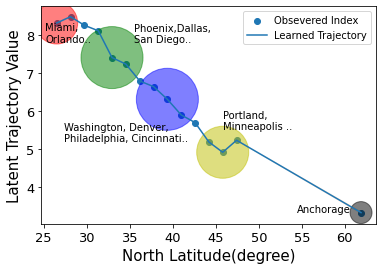

In [70]:
# lat traj plot
plt.figure(figsize=(6,4))
plt.scatter(lats,lat_traj_pred,label='Obsevered Index')
plt.plot(lats,lat_traj_pred,label='Learned Trajectory')
plt.fill_between(lats, lat_traj_pred - 3*np.sqrt(lat_traj_pred_v), lat_traj_pred + 3*np.sqrt(lat_traj_pred_v), alpha=0.2)

plt.xlabel('North Latitude(degree)', fontsize=15)
plt.ylabel('Latent Trajectory Value',fontsize=15)

city_names = ['Miami,\nOrlando..', 'Phoenix,Dallas, \nSan Diego..', 'Washington, Denver,\nPhiladelphia, Cincinnati.. ', 'Portland, \nMinneapolis ..', 'Anchorage']
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

state_id = [0,4,8,12,14]
state_size = [42**2,62**2,62**2,52**2,22**2]
state_color = ['r','g','b','y','k']

lats_state = lats[state_id]
lat_traj_pred_state = lat_traj_pred[state_id]


plt.scatter(lats_state,lat_traj_pred_state, c=state_color, s=state_size, alpha=0.5)


plt.annotate(city_names[0], xy=(lats_state[0], lat_traj_pred_state[0]),xycoords='data',xytext=(lats_state[0]-1.3, lat_traj_pred_state[0]-0.5), fontsize=10)

plt.annotate(city_names[1], xy=(lats_state[1], lat_traj_pred_state[1]),xycoords='data',xytext=(lats_state[1]+2.5, lat_traj_pred_state[1]+0.4), fontsize=10)

plt.annotate(city_names[2], xy=(lats_state[2]-5, lat_traj_pred_state[2]-0.5),xycoords='data',xytext=(lats_state[2]-12, lat_traj_pred_state[2]-1.1), fontsize=10)

plt.annotate(city_names[3], xy=(lats_state[3]-5, lat_traj_pred_state[3]-0.5),xycoords='data',xytext=(lats_state[3], lat_traj_pred_state[3]+0.6), fontsize=10)

plt.annotate(city_names[4], xy=(lats_state[4], lat_traj_pred_state[4]),xycoords='data',xytext=(lats_state[4]-7.5, lat_traj_pred_state[4]), fontsize=10)


plt.legend(fontsize=10)

file_name = 'figs/US_temp_lantide.pdf'
plt.savefig(file_name, format="pdf", bbox_inches="tight")

array([ 76.99,  91.46, 107.03, 121.33, 151.13])

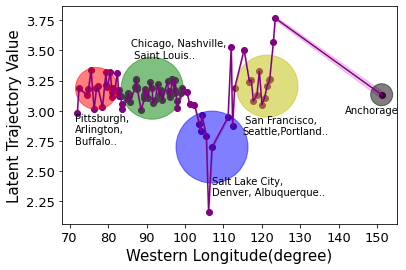

In [72]:
# lon traj plot
plt.figure(figsize=(6,4))
state_id = [6,44,76,89,-1]
lons[state_id]

plt.scatter(lons,lon_traj_pred,c='purple')
plt.plot(lons,lon_traj_pred,'purple',label='lat-traj-pred')

plt.fill_between(lons, lon_traj_pred - 3*np.sqrt(lon_traj_pred_v), lon_traj_pred + 3*np.sqrt(lon_traj_pred_v), color='m',alpha=0.2)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)


# state_id = [5,75,93,-1]
state_size = [42**2,62**2,72**2,62**2,22**2]
state_color = ['r','g','b','y','k']

lons_state= lons[state_id]
lons_traj_pred_state = lon_traj_pred[state_id]

plt.scatter(lons_state,lons_traj_pred_state, c=state_color, s=state_size, alpha=0.5)


city_names = ['Pittsburgh,\nArlington,\nBuffalo..', 'Chicago, Nashville,\n Saint Louis..', 'Salt Lake City,\nDenver, Albuquerque.. ', ' San Francisco,\nSeattle,Portland..', 'Anchorage']


plt.annotate(city_names[0], xy=(lons_state[0], lons_traj_pred_state[0]),xycoords='data',xytext=(lons_state[0]-5.5, lons_traj_pred_state[0]-0.46), fontsize=10)

plt.annotate(city_names[1], xy=(lons_state[1], lons_traj_pred_state[1]),xycoords='data',xytext=(lons_state[1]-5.5, lons_traj_pred_state[1]+0.25), fontsize=10)


plt.annotate(city_names[2], xy=(lons_state[2], lons_traj_pred_state[2]),xycoords='data',xytext=(lons_state[2], lons_traj_pred_state[2]-0.40), fontsize=10)


plt.annotate(city_names[3], xy=(lons_state[3], lons_traj_pred_state[3]),xycoords='data',xytext=(lons_state[3]-6.5, lons_traj_pred_state[3]-0.4), fontsize=10)

plt.annotate(city_names[4], xy=(lons_state[4], lons_traj_pred_state[4]),xycoords='data',xytext=(lons_state[4]-9.5, lons_traj_pred_state[4]-0.15), fontsize=10)

# plt.annotate(city_names[0], xy=(lats_state[0], lat_traj_pred_state[0]),xycoords='data',xytext=(lats_state[0]-1.3, lat_traj_pred_state[0]-0.5), fontsize=10)

# plt.annotate(city_names[1], xy=(lats_state[1], lat_traj_pred_state[1]),xycoords='data',xytext=(lats_state[1]+2.5, lat_traj_pred_state[1]+0.4), fontsize=10)

# plt.annotate(city_names[2], xy=(lats_state[2]-5, lat_traj_pred_state[2]-0.5),xycoords='data',xytext=(lats_state[2]-12, lat_traj_pred_state[2]-1.1), fontsize=10)

# plt.annotate(city_names[3], xy=(lats_state[3]-5, lat_traj_pred_state[3]-0.5),xycoords='data',xytext=(lats_state[3], lat_traj_pred_state[3]+0.6), fontsize=10)

# plt.annotate(city_names[4], xy=(lats_state[4], lat_traj_pred_state[4]),xycoords='data',xytext=(lats_state[4]-7.5, lat_traj_pred_state[4]), fontsize=10)


plt.xlabel('Western Longitude(degree)', fontsize=15)
plt.ylabel('Latent Trajectory Value',fontsize=15)

file_name = 'figs/US_temp_longitude.pdf'
plt.savefig(file_name, format="pdf", bbox_inches="tight")
# plt.legend()
# plt.legend()

In [29]:
fig = plt.figure()
size = fig.get_size_inches()*fig.dpi

<Figure size 432x288 with 0 Axes>

In [31]:
fig.dpi

72.0

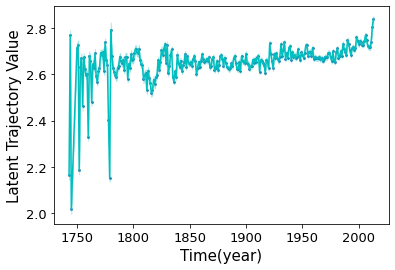

In [74]:
# year traj plot
plt.figure(figsize=(6,4))
plt.scatter(years,year_traj_pred, s = 3)
plt.plot(years,year_traj_pred,'c',label='year-traj-pred')

plt.fill_between(years, year_traj_pred - 3*np.sqrt(year_traj_pred_v), year_traj_pred + 3*np.sqrt(year_traj_pred_v), alpha=0.3, color='c')

plt.xlabel('Time(year)', fontsize=15)
plt.ylabel('Latent Trajectory Value',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.legend()
file_name = 'figs/US_temp_year.pdf'
plt.savefig(file_name, format="pdf", bbox_inches="tight")

In [136]:

def f_pred(X, Y, year_id):

    Z = np.zeros(X.shape)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):

            Z[i,j] = (lat_traj_pred[j] * lon_traj_pred[i] * year_traj_pred[year_id]).sum()
    return Z

year_id = -1
x = lat_idx
y = lon_idx
X, Y = np.meshgrid(x, y)
Z = f_pred(X, Y, year_id)
Z.shape

(95, 15)

In [137]:
# convert the data to [[lat, lon, value], ...] format
data = []
for lat_id in range(Z.shape[1]):
    for lon_id in range(Z.shape[0]):
        lat = lats[lat_id]
        lon = lons[lon_id]
        data.append([lat, -lon, Z[ lon_id, lat_id]])

In [138]:
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.patches import Circle, Rectangle, Arc

In [139]:
# Create map and display it use folium
from folium.plugins import HeatMap
us_map = folium.Map(location=[data[0][0], data[0][1]], zoom_start=4,tiles ="Stamen Toner")
HeatMap(data).add_to(us_map)
us_map

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


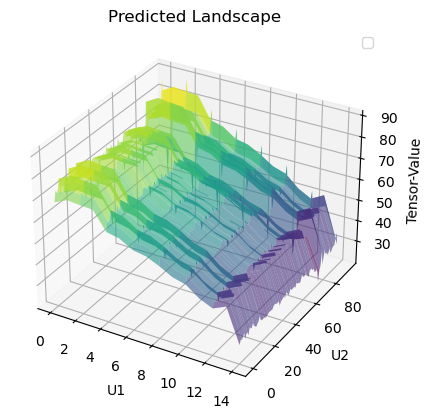

In [140]:

ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, Z, rstride=2, cstride=2,
                cmap='viridis', edgecolor='none', alpha=0.6)

# ax.scatter(X_train.reshape(-1), Y_train.reshape(-1),  Z_train.reshape(-1), c='red', marker='o', s=1,alpha=0.8, label='training data');

ax.set_title('Predicted Landscape');

ax.set_xlabel('U1')
ax.set_ylabel('U2')
ax.set_zlabel('Tensor-Value');

ax.legend()




